In [1]:
import numpy as np
import vgg16; reload(vgg16)
from vgg16 import Vgg16
import utils; reload(utils)
from utils import plots
import json

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [3]:
%matplotlib inline
np.set_printoptions(precision=4, linewidth=100)

In [4]:
sample = True

In [5]:
if sample:
    data = "data_sample/"
else:
    data = "data/"

In [6]:
batch_size = 64

In [7]:
vgg = Vgg16()

train_batches = vgg.get_batches(data+"train", batch_size=batch_size)
val_batches = vgg.get_batches(data+"valid", batch_size=batch_size)

Found 4650 images belonging to 2 classes.
Found 1618 images belonging to 2 classes.


In [8]:
vgg.finetune(train_batches)

In [9]:
vgg.fit(train_batches, val_batches, nb_epoch=1)

Epoch 1/1
4650/4650 [==============================] - 159s - loss: 0.2000 - acc: 0.9456 - val_loss: 0.0853 - val_acc: 0.9778


In [10]:
imgs, labels = next(train_batches)

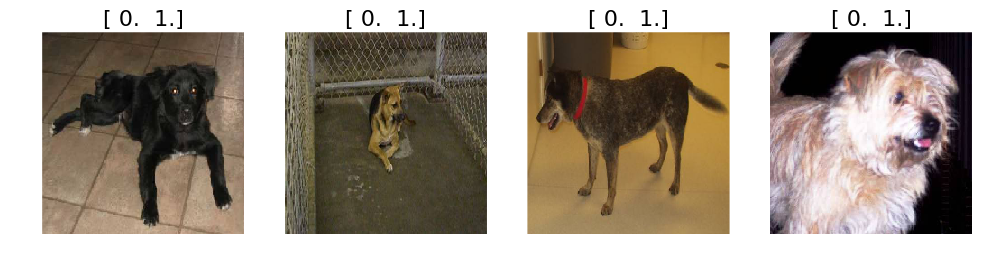

In [11]:
plots(imgs[:4], titles=labels[:4])

In [12]:
vgg.predict(imgs[:4], True)

(array([ 1.    ,  1.    ,  0.9995,  1.    ], dtype=float32),
 array([1, 1, 1, 1]),
 ['dogs', 'dogs', 'dogs', 'dogs'])

In [13]:
FILES_PATH='http://www.platform.ai/models/';  CLASS_FILE='imagenet_class_index.json'

In [14]:
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
classes = [class_dict[str(i)][1] for i in range(len(class_dict))] 

In [15]:
classes[:10]

[u'tench',
 u'goldfish',
 u'great_white_shark',
 u'tiger_shark',
 u'hammerhead',
 u'electric_ray',
 u'stingray',
 u'cock',
 u'hen',
 u'ostrich']

# Create a VGG model from scratch in Keras

In [16]:
def conv_block(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2,2))) 

In [17]:
def fc_block(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5)) 

In [18]:
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape(3,1,1)

def vgg_preprocess(x):
    x = x - vgg_mean
    return x[::-1, :]

In [19]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))
    
    conv_block(2, model, 64)
    conv_block(2, model, 128)
    conv_block(3, model, 256)
    conv_block(3, model, 512)
    conv_block(3, model, 512)
    
    model.add(Flatten())
    
    fc_block(model)
    fc_block(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [20]:
model = VGG_16()

In [21]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

In [22]:
def get_batches(dir_name, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(dir_name, target_size=(224,224),
                                   class_mode=class_mode, shuffle=shuffle, 
                                   batch_size=batch_size)

In [23]:
batches = get_batches(data+"train")
val_batches = get_batches(data+"valid")

Found 4650 images belonging to 2 classes.
Found 1618 images belonging to 2 classes.


In [24]:
imgs, labels = next(batches)

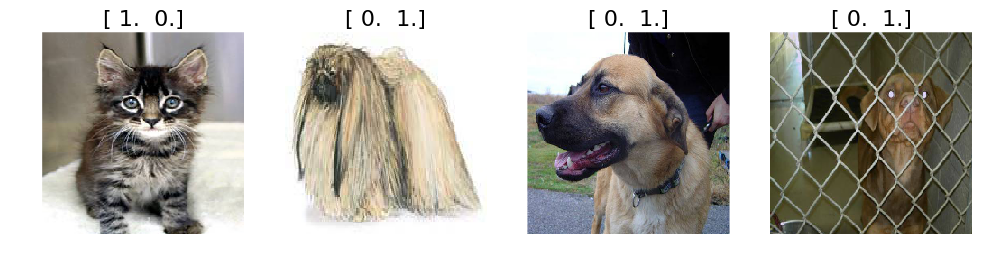

In [25]:
plots(imgs[:4], titles=labels[:4])

In [26]:
preds = model.predict(imgs)

In [27]:
idx = np.argmax(preds, axis=1)

In [28]:
idx

array([154, 281, 246, 166, 227, 193, 457, 287, 227, 227, 281, 250, 999, 285, 700, 457, 283, 285,
       171, 285, 210, 250, 224, 250, 285, 285, 227, 284, 489, 209, 228, 281, 285, 361, 164, 165,
       285, 700, 205, 285, 179, 210, 285, 249, 332, 254, 281, 876, 284, 155, 151, 212, 285, 220,
       200, 210, 171, 281, 232, 279, 264, 282, 235, 285])

In [29]:
for i in range(5):
#     print "First five classes: {}".format()
    print '{:.4f}/{}'.format(preds[i, idx[i]], classes[idx[i]])

0.1390/Pekinese
0.3661/tabby
0.5298/Great_Dane
0.1644/Walker_hound
0.9786/kelpie
